# But prise en main des objets créés par mes collègues et lancement d'un entrapînement à partir de la BDTOPO ou du RIL en tant que LAbel ??

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [129]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from utils import get_root_path

In [132]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt

In [151]:
os.environ["AWS_ACCESS_KEY_ID"]=
os.environ["AWS_SECRET_ACCESS_KEY"]=
os.environ["AWS_S3_ENDPOINT"]='minio.lab.sspcloud.fr'
os.environ["AWS_SESSION_TOKEN"]=

In [39]:
fs = get_file_system() # bien définir les variables d'environnement en amont !

In [ ]:
fs.ls('projet-slums-detection/Donnees/RIL/')

In [195]:
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"])
bucket = environment["bucket"]

path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]


'Donnees/BDTOPO/BDTOPO_3-0_TOUSTHEMES_SHP_UTM22RGFG95_D973_2022-03-15'

In [ ]:
# DL PLEIADE
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data}",
        lpath=f"../{path_local_pleiades_data}",
        recursive=True)


In [196]:
# DL BDTOPO
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)


## Chargement données pleiades

In [15]:
filename = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

datetime.datetime(2022, 7, 20, 0, 0)

In [109]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )
image.normalize()

In [117]:
list_images = image.split(250)
list_images[0].array
len(list_images)

64

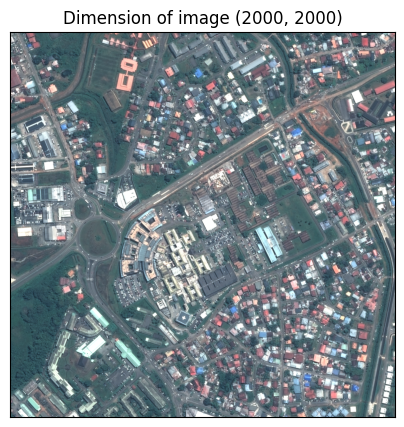

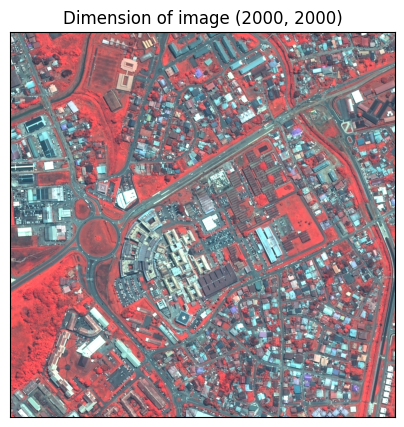

In [62]:
image.plot([0,1,2])image.plot([3,1,2])

## Représenter la liste des images sous forme de grille (ajouter une fonction)

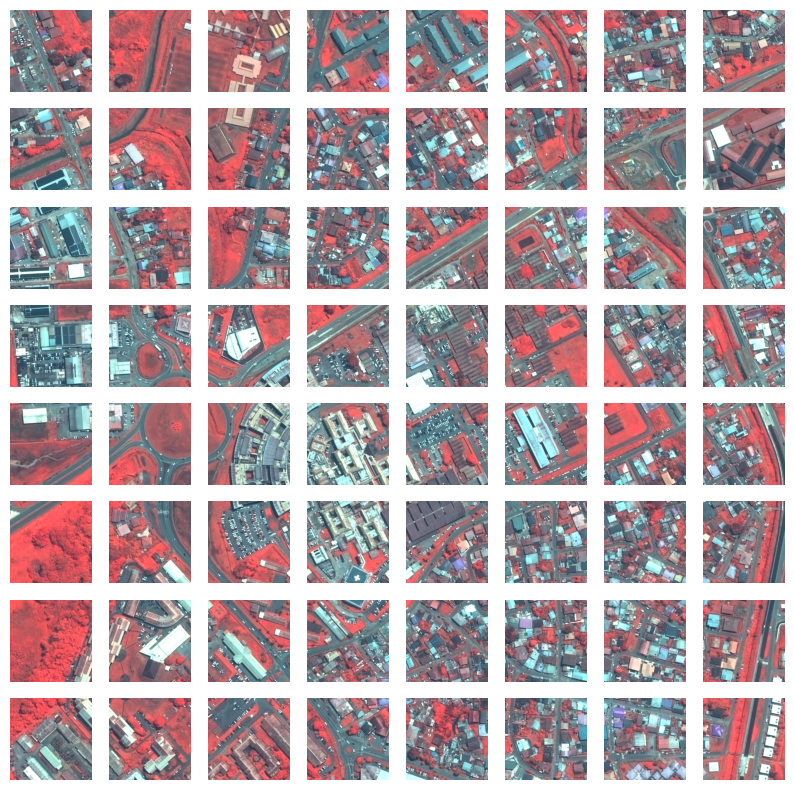

In [134]:
SatelliteImage.plot_list_satellite_images(list_images,bands_indices = [3,1,2])

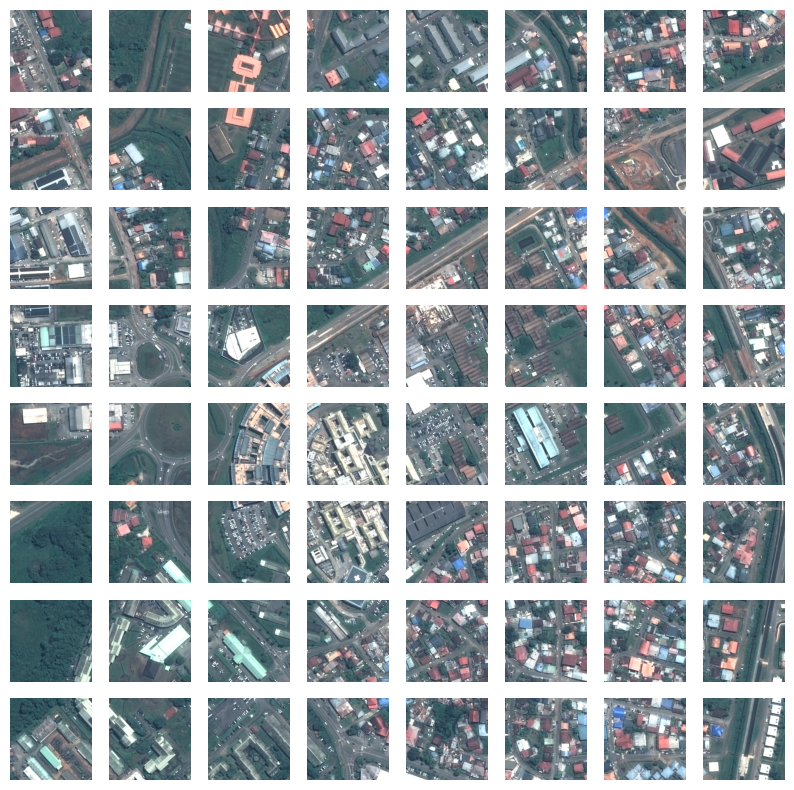

In [127]:
images = np.empty((n_col,n_row), dtype = object)

for i in range(n_col):
    for j in range(n_row):
        images[i,j] = mat_list_images[i,j].array_to_plot

images =np.flip(np.transpose(images),axis=0)
#mat_list_images = np.flip(np.transpose(mat_list_images),axis=0)

# Create a figure and axes
fig, axs = plt.subplots(nrows=n_col, ncols=n_row, figsize=(10, 10))

# Iterate over the images and plot them
for i in range(n_col):
    for j in range(n_row):
        axs[i,j].imshow(np.transpose(images[i,j], (1, 2, 0))[:, :, [0,1,2]])
        
# Remove any unused axes
for i in range(n_col):
    for j in range(n_row):
        axs[i,j].set_axis_off()

# Show the plot
plt.show()


In [ ]:
image.bounds[0]
image.bounds[1]
image.bounds[2]
# Plus qu'à utiliser la fonction que j'ai créée pour l'affichage d'une grille ?
# mettre certains notebooks dans du #old !

354000.0

In [78]:
64*256 # nb de patchs utilisables pour entrainer un modèle, why not ?

16384

In [35]:
#image.plot([0,1,2])
image.normalized # ok le plot normalise l'image donc attention  ? j'aurais tendanc e à l'enlever moi

True

## Récupération des labellisations

In [37]:
from labeler import RILLabeler

Définition d'une instance de labeller (on donneune datez et un département et on va chercher les labels associés RIL à côté)

In [164]:
labeler = RILLabeler(date, dep = "973", buffer_size= 20)

In [165]:
mask = labeler.create_segmentation_label(image) # va chercher les données et rasterise les bounding box

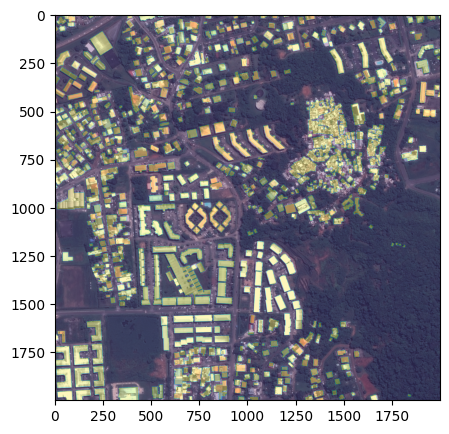

In [201]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

# Plus qu'à faire la même chose sur le mont baduel :)

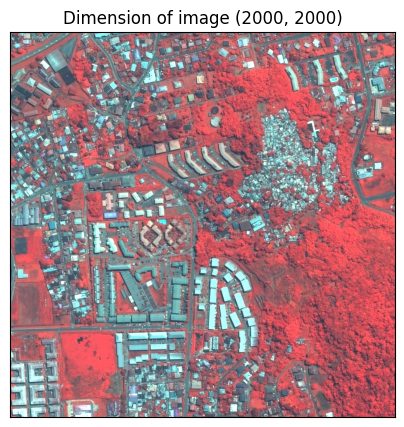

In [175]:
filename = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0354_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )

image.plot([3,1,2])

## Ril

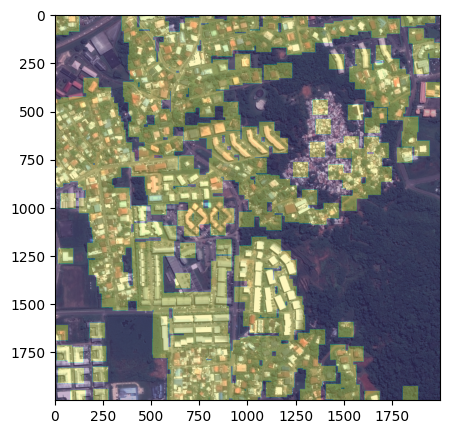

In [202]:

labeler = RILLabeler(date, dep = "973", buffer_size= 20)
mask = labeler.create_segmentation_label(image)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

## BD TOPO

In [179]:
from labeler import BDTOPOLabeler

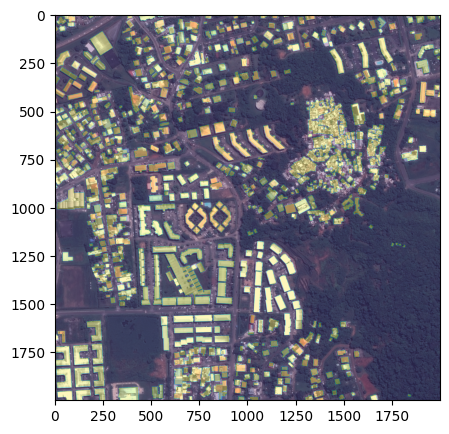

In [203]:
labeler = BDTOPOLabeler(date, dep = "973") # charghement lenbt nécessite d'avoir downloader la BDTOPO avant. fluidifier ça ?
mask = labeler.create_segmentation_label(image)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3) # magnifique ! Faire une fonction  de représentation  ? # faire du découpage ? ou une fonction de sélection aléatoire d'une tuile ?

Le moint Baduel a bien été cartographié !

## Mélange images Labels !

In [1]:
from labeled_satellite_image import SegmentationLabeledSatelliteImage

ModuleNotFoundError: No module named 'labeled_satellite_image'

In [ ]:
Segme

## TO DO 

- fonctions de représentations ?
- création d'une classe Dataset particulière avec les aleas 
- ajout de fonctions de représentations
- bérifier qu'on retrouve bien la géométrie à partir de l'image et vice versa
- Quand on fait du plot, ne pas normaliser l'arraymais en faire une copie pour normaliser ensuite et représenter la normalisation sera différente pour les réseaux -> Done j'ai fait un array_to_plot
- Faire une fonction create bounding box pour yolo etc.. c'est l'objet de create detection label , faire une fonction de représentation ?
- access Vault ?
- Faire un notebook de prise en main pour les stagiaires
- chargement super lent de la BDTOPO, que faire ?
- faire une fonction plot label on images (superposition)
- faire une fonction plot label next to image
- faire une fonction plot lioste image